# Tiny Stories Hackathon
> From Cluster of stars study group

## TinyStories Hackathon Rules
This hackathon is intended to be a fun competition to give ourselves practice pretraining LLMs on consumer hardware. We will follow the [TinyStories paper](<https://arxiv.org/abs/2305.07759>) and train small language models on small datasets and hardware.

The hackathon will end on April 7th, [AOE](<https://en.wikipedia.org/wiki/AoE>).

### Datasets
1. [**TinyStories:**](<https://huggingface.co/datasets/roneneldan/TinyStories>)
   Note that the TinyStories dataset is split into two versions both in the HF dataset:
     - GPT-3.5 generated TinyStories
    - GPT-4 generated TinyStories
   The tar file appears to have the cleanest versions with the least number of duplicates.
2. **[Simple Wikipedia](<https://huggingface.co/datasets/lsb/simplewiki2023>)** (optional)
   This dataset can be used to give your model more world knowledge than from just the TinyStories dataset. But be careful that 
it doesn't cause your model to use words which a typical 3 to 4-year-olds doesn't understand. It may need to be cleaned.

### Evaluation
Models will be evaluated by LLM-as-a-judge following the methodology outlined in the TinyStories paper. More details including how to submit your model's outputs early next week.

### Model Size Limits
Participants will be slotted into one of the following categories based on their hardware:
- **Small**: Up to 30M parameters. Low-to-mid range laptop GPUs and Apple Silicon.
- **Medium**: Up to 60M parameters. Mid-range GPUs (including high-end laptop GPUs and Apple Silicon)
- **Large**: Up to 120M parameters. High-end GPUs and multi-GPU systems.

### Tokenizers
While you must train your model from scratch, you are welcome to use any pre-trained tokenizer or train your own tokenizer.

### Model Architecture
You are welcome to use any model architecture you want provided you stay within the parameter budget of your hardware by following the parameter counting rules below.

### Parameter Counting
The Parameter budget is the number of unique floating-point weights receiving gradient updates:
- Unique Weights: Count each distinct floating-point weight stored in the model once.
- Reuse Multiplier: For each weight, multiply by the number of distinct times it contributes to forward computation (e.g., due to layer-sharing, layer reuse, or non-standard head-sharing). Weight-tied embedding and decoder weights are the exception and are only counted once. MQA/GQA doesn't count as head-sharing.

### Teams
Teams are limited to a maximum of 2 members and must be formed and declared within the first week.

### Training Frameworks
You might want to take a look at the following libraries and frameworks and adopt one for pretraining:
- [Composer](<https://docs.mosaicml.com/projects/composer/en/stable/index.html>) and optionally [LLM Foundry](<https://github.com/mosaicml/llm-foundry>)
- [PyTorch Lightning](<https://lightning.ai/docs/pytorch/stable/>) and optionally [LitGPT](<https://github.com/Lightning-AI/litgpt>)
- Hugging Face [Trainer](<https://huggingface.co/docs/transformers/en/main_classes/trainer>), [Accelerate](<https://huggingface.co/docs/accelerate/en/index>), and optionally [Axolotl](<https://axolotl-ai-cloud.github.io/axolotl/>) (a wrapper on top of HF)
- [fastai](<https://docs.fast.ai/>) with either [fastxtend](<https://fastxtend.benjaminwarner.dev/text.huggingface.html>)/[blurr](<https://ohmeow.github.io/blurr/>)

## Data

### Dataset (?)

In [1]:
from datasets import load_dataset
import tiktoken
import torch

from minai import *

Grab tiny stories data from hugging face.

In [2]:
ds = load_dataset('roneneldan/TinyStories')
trn = ds['train']
val = ds['validation']
trn

Dataset({
    features: ['text'],
    num_rows: 2119719
})

For now, we can just use gpt2 tokenizer to get started.

In [3]:
tokenizer = tiktoken.get_encoding('gpt2')

txt = trn[0]['text']
txt

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

In [4]:
tokenizer.encode(txt)[:10]

[3198, 1110, 11, 257, 1310, 2576, 3706, 20037, 1043, 257]

In [5]:
tokenizer.decode(tokenizer.encode(txt)[:10])

'One day, a little girl named Lily found a'

Let's encode them.

In [6]:
def encode(b):
    b['text'] = [tokenizer.encode(o, allowed_special={'<|endoftext|>'}) for o in b['text']]
    return b

In [7]:
ds = ds.with_transform(encode)
trn = ds['train']
val = ds['validation']
trn

Dataset({
    features: ['text'],
    num_rows: 2119719
})

Now we have numbers. We have to decode them to read text.

In [8]:
trn[0]['text'][:5]

[3198, 1110, 11, 257, 1310]

In [9]:
tokenizer.decode(trn[0]['text'])

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

### Chunk

In [10]:
seq_len = 256
chunk_sz = seq_len + 1
eot_token = 50256
eot_tensor = torch.tensor([eot_token])

div_by = 10000

Let's try to use 1% data to get started. Our goal is to add `eot_token` to the end of each text. Then, chop them up into `seq_len` to create each batch.

In [11]:
data_len = trn.num_rows // div_by // 3
data_len

70

In [12]:
seq_tensor = [torch.tensor(o) for o in trn[:data_len]['text']]
seq_tensor[0]

tensor([ 3198,  1110,    11,   257,  1310,  2576,  3706, 20037,  1043,   257,
        17598,   287,   607,  2119,    13,  1375,  2993,   340,   373,  2408,
          284,   711,   351,   340,   780,   340,   373,  7786,    13, 20037,
         2227,   284,  2648,   262, 17598,   351,   607,  1995,    11,   523,
          673,   714, 34249,   257,  4936,   319,   607, 10147,    13,   198,
          198,    43,   813,  1816,   284,   607,  1995,   290,   531,    11,
          366, 29252,    11,   314,  1043,   428, 17598,    13,  1680,   345,
         2648,   340,   351,   502,   290, 34249,   616, 10147,  1701,  2332,
         1995, 13541,   290,   531,    11,   366,  5297,    11, 20037,    11,
          356,   460,  2648,   262, 17598,   290,  4259,   534, 10147,   526,
          198,   198, 41631,    11,   484,  4888,   262, 17598,   290,   384,
        19103,   262,  4936,   319, 20037,   338, 10147,    13,   632,   373,
          407,  2408,   329,   606,   780,   484,   547,  7373, 

In [13]:
cat = torch.cat([torch.cat([s, eot_tensor]) for s in seq_tensor])
cat[:200]

tensor([ 3198,  1110,    11,   257,  1310,  2576,  3706, 20037,  1043,   257,
        17598,   287,   607,  2119,    13,  1375,  2993,   340,   373,  2408,
          284,   711,   351,   340,   780,   340,   373,  7786,    13, 20037,
         2227,   284,  2648,   262, 17598,   351,   607,  1995,    11,   523,
          673,   714, 34249,   257,  4936,   319,   607, 10147,    13,   198,
          198,    43,   813,  1816,   284,   607,  1995,   290,   531,    11,
          366, 29252,    11,   314,  1043,   428, 17598,    13,  1680,   345,
         2648,   340,   351,   502,   290, 34249,   616, 10147,  1701,  2332,
         1995, 13541,   290,   531,    11,   366,  5297,    11, 20037,    11,
          356,   460,  2648,   262, 17598,   290,  4259,   534, 10147,   526,
          198,   198, 41631,    11,   484,  4888,   262, 17598,   290,   384,
        19103,   262,  4936,   319, 20037,   338, 10147,    13,   632,   373,
          407,  2408,   329,   606,   780,   484,   547,  7373, 

In [14]:
cat.shape

torch.Size([12645])

Let's create batches with `seq_length`.

In [15]:
num_complete_segments = cat.size(0) // chunk_sz
num_complete_segments

12

In [16]:
complete_segments = cat[:num_complete_segments * chunk_sz].view(-1, chunk_sz)
complete_segments.shape

torch.Size([12, 1025])

> TODO

Looking at the last bit, it is pretty close to a whole `seq_len`. We can pad it and use it later.

In [17]:
remainder = cat[num_complete_segments * seq_len:]
remainder.shape

torch.Size([357])

### Dataset (!)

Let's create inputs and targets for a dataset.

In [18]:
inps = complete_segments[:, :-1]
targs = complete_segments[:, 1:]
inps.shape, targs.shape

(torch.Size([12, 1024]), torch.Size([12, 1024]))

In [19]:
inps[0][:20]

tensor([ 3198,  1110,    11,   257,  1310,  2576,  3706, 20037,  1043,   257,
        17598,   287,   607,  2119,    13,  1375,  2993,   340,   373,  2408])

In [20]:
targs[0][:20]

tensor([ 1110,    11,   257,  1310,  2576,  3706, 20037,  1043,   257, 17598,
          287,   607,  2119,    13,  1375,  2993,   340,   373,  2408,   284])

We can create a dataset now.

In [21]:
trn_ds = Dataset(inps, targs)
trn_ds[0]

(tensor([ 3198,  1110,    11,  ..., 24829,   284,   262]),
 tensor([1110,   11,  257,  ...,  284,  262, 7586]))

We got the training dataset. Now, we can get the validation dataset with the same approach.

In [22]:
val_data_len = val.num_rows // div_by * 10
val_data_len

20

In [23]:
val_seq_tensor = [torch.tensor(o) for o in val[:val_data_len]['text']]
val_seq_tensor[0]

tensor([32565,    13, 15899,  2497,   262, 22441,  1097,   290,   531,    11,
          366, 22017,    11, 21168,    11,   534,  1097,   318,   523,  6016,
          290,  3424,  2474, 21168, 13541,   290,  8712,    11,   366, 10449,
          345,    11, 15899,    13,   314, 25245,   340,   790,  1110,   526,
          198,   198,  3260,  2712,   351,   262,  1097,    11, 21168,   290,
        15899,  2936, 47124,    13,  1119,  1043,   257,  1402, 16723,   351,
         1598,  1660,    13,  1119, 24070,   262,  1660,   290,  2936,   845,
         3772,    13,  1119,  2826,  1978,   477,  1110,   290,  2627,  1266,
         2460,    13])

In [24]:
val_cat = torch.cat([torch.cat([s, eot_tensor]) for s in val_seq_tensor])
val_cat[:200]

tensor([32565,    13, 15899,  2497,   262, 22441,  1097,   290,   531,    11,
          366, 22017,    11, 21168,    11,   534,  1097,   318,   523,  6016,
          290,  3424,  2474, 21168, 13541,   290,  8712,    11,   366, 10449,
          345,    11, 15899,    13,   314, 25245,   340,   790,  1110,   526,
          198,   198,  3260,  2712,   351,   262,  1097,    11, 21168,   290,
        15899,  2936, 47124,    13,  1119,  1043,   257,  1402, 16723,   351,
         1598,  1660,    13,  1119, 24070,   262,  1660,   290,  2936,   845,
         3772,    13,  1119,  2826,  1978,   477,  1110,   290,  2627,  1266,
         2460,    13, 50256,  7454,  2402,   257,   640,    11,   287,   257,
         1263,  8222,    11,   612,  5615,   257,  9529,   259,   420, 27498,
         3706,   371, 23536,    13,   371, 23536,  6151,   284, 12080,    13,
         1375, 19952,  7150,    11, 12586,    11,   290, 18639,    13,  1881,
         1110,    11,   371, 23536,  1043,   281, 30284, 12788, 

In [25]:
val_num_complete_segments = val_cat.size(0) // chunk_sz
val_num_complete_segments

3

In [26]:
val_complete_segments = val_cat[:val_num_complete_segments * chunk_sz].view(-1, chunk_sz)
val_complete_segments.shape

torch.Size([3, 1025])

In [27]:
val_inps = val_complete_segments[:, :-1]
val_targs = val_complete_segments[:, 1:]
val_inps.shape, val_targs.shape

(torch.Size([3, 1024]), torch.Size([3, 1024]))

In [28]:
val_ds = Dataset(val_inps, val_targs)
val_ds[0]

(tensor([32565,    13, 15899,  ...,    13,  4186,   373]),
 tensor([   13, 15899,  2497,  ...,  4186,   373,  3772]))

### DataLoader

We need a dataloader with the batch size.

In [29]:
bs = 4

trn_dl, val_dl = get_dls(trn_ds, val_ds, bs)
dls = DataLoaders(trn_dl, val_dl)
xb,yb = next(iter(trn_dl))
xb.shape,yb.shape

(torch.Size([4, 1024]), torch.Size([4, 1024]))

In [30]:
xb[:5], yb[:5]

(tensor([[  290,  3409,    13,  ...,   703,  5802,   340],
         [  257,  1310,  2933,  ...,   887,   428,   640],
         [  286,  2842,    13,  ..., 12615,   257, 41236],
         [34681,   461,   290,  ...,   383, 21613,   373]]),
 tensor([[ 3409,    13,  1119,  ...,  5802,   340,  3947],
         [ 1310,  2933,  3706,  ...,   428,   640,    11],
         [ 2842,    13, 50256,  ...,   257, 41236,    13],
         [  461,   290,  2921,  ..., 21613,   373,  1402]]))

## Model

We make the model using transformer.

In [31]:
import torch.nn as nn

### MultiHeadAttention

Here's the `MultiHeadAttention` with Causal attention.

In [32]:
set_seed(42)
x = torch.randn((2, 2, 3)) # (bs, ctx_len, d_in)

In [35]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, ctx_len, n_head, qkv_bias=False):
        super().__init__()
        assert (d_out % n_head == 0), "d_out must be divisible by num_heads"
        self.n_head = n_head
        self.d_in = d_in
        self.d_out = d_out
        self.head_dim = d_out // n_head
        self.w_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.register_buffer("mask", torch.triu(torch.ones((ctx_len, ctx_len)), diagonal=1).bool())
    
    def forward(self, x): 
        bs, num_tokens, d_in = x.shape
        q = self.w_q(x)  # (bs, num_tokens, d_out)
        k = self.w_k(x)
        v = self.w_v(x)
        
        q = q.view(bs, num_tokens, self.n_head, self.head_dim)  # (bs, num_tokens, n_head, head_dim)
        k = k.view(bs, num_tokens, self.n_head, self.head_dim)
        v = v.view(bs, num_tokens, self.n_head, self.head_dim)
        
        q = q.transpose(1,2) # (bs, n_head, num_tokens, head_dim)
        k = k.transpose(1,2)
        v = v.transpose(1,2)
        
        attn_scr = q@k.transpose(2,3) # (bs, n_head, num_tokens, num_tokens)
        attn_scr = attn_scr.masked_fill(self.mask[:num_tokens, :num_tokens], -torch.inf)
        attn_wt = torch.softmax(attn_scr / k.shape[-1]**0.5, -1)
        
        ctx_vec = attn_wt@v  # (bs, n_head, num_tokens, head_dim)
        ctx_vec = ctx_vec.transpose(1,2).reshape(bs, num_tokens, -1) # (bs, num_tokens, d_out)
        
        # concat
        return ctx_vec

In [36]:
mha = MultiHeadAttention(d_in=3, d_out=4, ctx_len=2, n_head=2)
mha(x), mha(x).shape  # Outputs (bs, num_tokens, d_out)

(tensor([[[ 0.1778, -0.1473,  0.1028,  0.0059],
          [ 0.1752,  0.0355,  0.1155,  0.3003]],
 
         [[ 1.0137, -0.7234,  0.5223,  0.9915],
          [ 0.6409, -0.4204,  0.3602,  0.2310]]], grad_fn=<UnsafeViewBackward0>),
 torch.Size([2, 2, 4]))

In [37]:
batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


### FeedForward

In [38]:
class FeedForward(nn.Module):
    def __init__(self, in_dim, hidden_dim, act=nn.ReLU()):
        super().__init__()
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.act = act
        self.l2 = nn.Linear(hidden_dim, in_dim)
    
    def forward(self, x):
        return self.l2(self.act(self.l1(x)))

In [39]:
set_seed(42)
x = torch.randn(4)
ff = FeedForward(4, 4*4)
ff(x), ff(x).shape

(tensor([-0.2928, -0.1471,  0.0123, -0.2592], grad_fn=<ViewBackward0>),
 torch.Size([4]))

### Transformer Block

In [40]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, ctx_len, n_head, drop_out=0, ff_mult=4, qkv_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ln2 = nn.LayerNorm(emb_dim)
        self.mha = MultiHeadAttention(emb_dim, emb_dim, ctx_len, n_head, qkv_bias=qkv_bias)
        self.do = nn.Dropout(drop_out)
        self.ff = FeedForward(emb_dim, emb_dim*ff_mult)
    
    def forward(self, x):
        skip1 = x
        x = self.ln1(x)
        x = self.mha(x)
        x = self.do(x)
        x = x + skip1
        
        skip2 = x
        x = self.ln2(x)
        x = self.ff(x)
        x = self.do(x)
        x = x + skip2
        return x

In [41]:
set_seed(42)
x = torch.randn((2, 2, 3)) # (bs, ctx_len, d_in)
tb = TransformerBlock(emb_dim=3, ctx_len=2, n_head=1)
tb(x), tb(x).shape

(tensor([[[-0.3595, -1.0631,  0.5676],
          [-0.3159, -2.2222,  0.1778]],
 
         [[ 1.7169, -1.7565,  1.2721],
          [-0.3908, -0.2502,  0.3274]]], grad_fn=<AddBackward0>),
 torch.Size([2, 2, 3]))

### GPT model

In [75]:
768 / 2 / 2 / 2 / 2

48.0

In [76]:
cfg = {
    'n_tb': 1,    # num transformer blocks
    'vocab_sz': 50257,
    'emb_sz': 3,
    'emb_dim': 48,
    'ctx_len': seq_len,
    'n_head': 1,
    'drop_out': 0,
    'drop_out_tb': 0,  # dropout within transformer blocks
    'ff_mult': 4,
    'qkv_bias': False,
     }

In [77]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.do = nn.Dropout(cfg['drop_out'])
        self.tb = nn.Sequential(
            *[TransformerBlock(cfg['emb_dim'], cfg['ctx_len'], cfg['n_head'], cfg['drop_out_tb'],
                              cfg['ff_mult'], cfg['qkv_bias']) for _ in range(cfg['n_tb'])])
        self.final_ln = nn.LayerNorm(cfg['emb_dim'])
        self.final_l  = nn.Linear(cfg['emb_dim'], cfg['vocab_sz'])
    
    def forward(self, x):
        bs, seq_len = x.shape
        tok = self.token_emb(x)
        pos = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = self.do(tok + pos)
        x = self.tb(x)
        x = self.final_ln(x)
        x = self.final_l(x)
        return x

In [78]:
batch = xb[:3]
batch.shape

torch.Size([3, 1024])

In [80]:
set_seed(42)
model = GPTModel(cfg)
logits = model(batch)
logits.shape

torch.Size([3, 1024, 50257])

In [98]:
def get_total_params(model): 
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params:,}")
    return total_params
total_params = get_total_params(model)

Total number of parameters: 7,313,137


In [89]:
model.token_emb.weight.shape, model.final_l.weight.shape

(torch.Size([50257, 48]), torch.Size([50257, 48]))

In [96]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 27.90 MB


In [101]:
def get_total_memory(model):
    total_params = get_total_params(model)
    total_size_bytes = total_params * 4
    # Convert to megabytes
    total_size_mb = total_size_bytes / (1024 * 1024)
    print(f"Total size of the model: {total_size_mb:.2f} MB")

get_total_memory(model)

Total number of parameters: 7,313,137
Total size of the model: 27.90 MB


### Text generation

In [81]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [82]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [83]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=cfg["ctx_len"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 38213, 23676,  9929, 29854,  3414, 22988]])
Output length: 10


In [84]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Moves Poor overt DV announcedpeace


In [85]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=cfg["ctx_len"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you589bj cartoon regional Islamabad Experimental Cancer straw unin fucked


In [86]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [57]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [58]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[20642],
         [38668],
         [12967]],

        [[49254],
         [25070],
         [38158]]])


In [59]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Kurtepisode pig


In [60]:
print("Train loader:")
for x, y in trn_dl:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_dl:
    print(x.shape, y.shape)

Train loader:
torch.Size([4, 1024]) torch.Size([4, 1024])
torch.Size([4, 1024]) torch.Size([4, 1024])
torch.Size([4, 1024]) torch.Size([4, 1024])

Validation loader:
torch.Size([3, 1024]) torch.Size([3, 1024])


In [61]:
train_tokens = 0
for input_batch, target_batch in trn_dl:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_dl:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 12288
Validation tokens: 3072
All tokens: 15360


In [62]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [63]:
import torch.nn.functional as F

In [64]:
def loss_fn(pred, targ): return F.cross_entropy(pred.flatten(0, 1), targ.flatten())

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(trn_dl, model, device)
    val_loss = calc_loss_loader(val_dl, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.997873306274414
Validation loss: 10.994172096252441


In [66]:
cbs = [MetricsCB(), ProgressCB()]

In [67]:
model.train()

GPTModel(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(50257, 768)
  (do): Dropout(p=0, inplace=False)
  (tb): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (w_q): Linear(in_features=768, out_features=768, bias=False)
        (w_k): Linear(in_features=768, out_features=768, bias=False)
        (w_v): Linear(in_features=768, out_features=768, bias=False)
      )
      (do): Dropout(p=0, inplace=False)
      (ff): FeedForward(
        (l1): Linear(in_features=768, out_features=3072, bias=True)
        (act): ReLU()
        (l2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (final_ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (final_l): Linear(in_features=768, out_features=50257, bias=True)
)

loss,epoch,train,time
10.998,0,train,00:08
10.998,1,train,00:09


KeyboardInterrupt: 

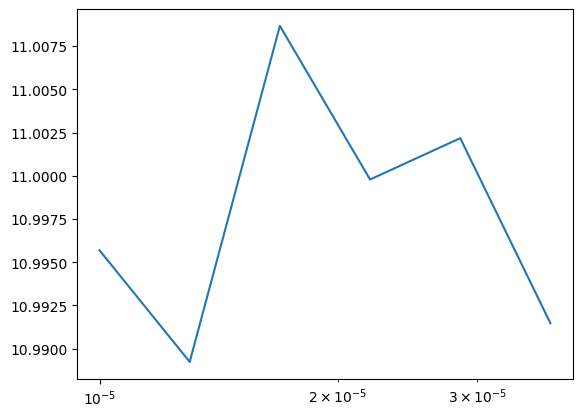

In [68]:
learn = TrainLearner(model, dls, loss_func=loss_fn, cbs=cbs)
learn.lr_find()

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

Hyperparameters: Learning rate, optimizer: Gradient clipping, batch size: 4k

Mixed precision -> weight decay needed. (bfloat16)

Distributed data parallel: Split data into 2 and use graident accumulation

Fully Sharded data parallel: shard of data into GPUs as layer goes.

CPU offload

DataLoader: Use for loop.

!!!!! Look at the data. !!!!!

Eval: next token accuracy, loss

Try GLU instead of ReLU

Tips: 

1. Try simple model.
2. Weight Tying.
3. Hyperparameter sweep
4. 


Get sequencing packing to work -> iterate faster
flash attention.